# Experimentation - Sampling

In our previous notebook "EDA", we have noticed that our data was imbalanced. Therefore, we were confronted to an anomaly dectection problem. 
Our objective will be to correctly classify the minority class of `Fake`events.

What we are going to do:
- Feature selection
- This imbalance can be reduced by under-sampling the majority class `Not fake`, by making it close to that of the `Fake` class.
- Model Training
- Model Evaluation

Time for experimentation
There are no "Null" values, so we don't have to work on ways to replace values. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("../data/fake_users.csv")

# Unnamed and UserId are dataset artifact, not something useful for analysis
df.drop("Unnamed: 0", axis=1, inplace=True)
df.drop("UserId", axis=1, inplace=True)

# let's make a copy of our orignal dataset
df_feat = df.copy()

# A quick reminder of how the data looks like
df_feat.head()

,Event,Category,Fake
0,click_carrousel,Phone,0
1,send_sms,Motor,0
2,send_email,Jobs,0
3,send_sms,Jobs,0
4,click_ad,Phone,0


# Featurize

Our `Event` and `Category` columns hold nominal categorial data where there are no inherent order (in opposition to ordinal categorial data). These "categories" must be transformed into numbers first, before you can apply the learning algorithm on them.

To achieve that there are different encoding techniques.
- Label Encoding: each label is converted into an integer value based on conversion dictionnary 
- One Hot Encoding: each category is mapped with a binary variable containing either 0 or 1. Here, 0 represents the absence, and 1 represents the presence of that category.
- Hash Encoding: each category is encoded using a hash function. It is a good solution when the cardinality of the category is too high.  

We will user one hot encoding, because the cardinality of our categories are rather low.

In [3]:
df_feat = pd.get_dummies(df_feat, columns=['Event'], prefix = ['Event'])
df_feat = pd.get_dummies(df_feat, columns=['Category'], prefix = ['Category'])
df_feat.head()

,Fake,Event_click_ad,Event_click_carrousel,Event_phone_call,Event_send_email,Event_send_sms,Category_Holidays,Category_Jobs,Category_Leisure,Category_Motor,Category_Phone,Category_Real_State
0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,1,0


In [4]:
original_df_feat = df_feat.copy()

Now let's separate our class from the rest of the data.

In [5]:
y_train = df_feat.pop("Fake")
X_train = df_feat

In [6]:
print(f'Dimension of training, X: {X_train.shape}, y: {y_train.shape}')

Dimension of training, X: (100473, 11), y: (100473,)


In [21]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from IPython.display import display


'''Test options and evaluation metric'''
def BasedLine(X_train, y_train, models, scoring = "accuray", num_folds = 10):

    results, names = [], []

    for name, model in models.items():
        kfold = StratifiedKFold(n_splits = num_folds)
        
        y_pred = cross_val_predict(model, X_train, y_train, cv=kfold)
        conf_mat = confusion_matrix(y_train, y_pred)
        
        cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring, n_jobs = -1)


        names.append(name)
        print(name)
        display(pd.DataFrame(conf_mat))
    
    return names, results

# Sampling

There are several sampling techniques:
- Undersampling: select a subset of examples from the majority class.
- Oversampling: duplicate examples in the minority class or synthesize new examples from the examples in the minority class.
- Combinations of Techniques: applying both undersampling and oversampling techniques together.

Each technique has several implementation methods. In our case we will use Random Undersampling. It consists in selecting randomly a subest of the majority class.

In [22]:
df_feat = original_df_feat.sample(frac=1)

nb_fake = df_feat['Fake'].value_counts()[1]
print(nb_fake)

# amount of fraud classes 10359 rows.
fake_df = df_feat.loc[df_feat['Fake'] == 1]
not_fake_df = df_feat.loc[df_feat['Fake'] == 0][:nb_fake]

normal_distributed_df = pd.concat([fake_df, not_fake_df], ignore_index=True)

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42, ignore_index=True)


10359


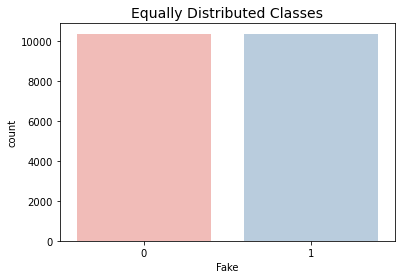

In [23]:
sns.countplot(x='Fake', data=new_df, palette="Pastel1")
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [24]:
new_y_train = new_df.pop("Fake")
new_X_train = new_df

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = {'DUM' : DummyClassifier(),
          'LR' :LogisticRegression(solver='lbfgs') ,
          'KNN' : KNeighborsClassifier(),
          'DT': DecisionTreeClassifier(),
         }

names,results = BasedLine(new_X_train, new_y_train,models, "f1", 5)

DUM


,0,1
0,8287,2072
1,8288,2071


LR


,0,1
0,6184,4175
1,1546,8813


KNN


,0,1
0,6922,3437
1,4076,6283


DT


,0,1
0,6184,4175
1,1546,8813


# Model tunning

In [30]:
from sklearn.model_selection import GridSearchCV
seed = 44
def grid_search_cv(model, params, scoring="f1", cv = 10):    
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv = cv, verbose = 1,
                             scoring = scoring, n_jobs = -1)
    grid_search.fit(new_X_train, new_y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    
    return best_estimator, best_params, best_score

In [31]:
LR_model = LogisticRegression()

LR_params = [
  {'penalty': ['l1'], 'solver': [ 'saga','liblinear'], 'C': [ 0.01,0.1, 1, 10]},
  {'penalty': ['l2'], 'solver': ['newton-cg', 'sag', 'saga','lbfgs'], 'C': [ 0.01,0.1, 1, 10]},
 ]


LR_best_estimator, LR_best_params, LR_best_score= grid_search_cv(LR_model, LR_params, scoring="f1", cv= 5)
print(f"LR best params:{LR_best_params} & best_score:{LR_best_score:0.5f} / {LR_best_estimator}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
LR best params:{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'} & best_score:0.75493 / LogisticRegression(C=0.01, penalty='l1', solver='saga')


In [ ]:
knears_params = {"n_neighbors": [2, 3, 4, 5], 'algorithm': ['auto', 'ball_tree', 'kd_tree'], "weights": ['uniform', 'distance']}

KNN_model = KNeighborsClassifier()
grid_knears = GridSearchCV(KNN_model, knears_params)

KNN_best_estimator, KNN_best_params, KNN_best_score= grid_search_cv(KNN_model, knears_params, scoring="f1", cv= 5)
print(f"KNN best params:{KNN_best_params} & best_score:{KNN_best_score:0.3f} / {KNN_best_estimator}")

In [ ]:
print(grid_knears.best_estimator_, grid_knears.best_params_, grid_knears.best_score_)

# Model testing

In [42]:
df_test = pd.read_csv("../data/fake_users_test.csv")
df_test.head()

,UserId,Event,Category,Fake
0,03E7EE785DT,click_carrousel,Phone,0
1,F0F3098683T,click_ad,Leisure,0
2,5064A38F0DT,click_carrousel,Phone,0
3,5C8E90A354T,click_carrousel,Motor,0
4,DC1F29D286T,send_sms,Motor,0


In [43]:
y_test = df_test.pop("Fake")
X_test = df_test

X_test_f= df_test.iloc[:,1:]
X_test_f = pd.get_dummies(X_test_f, columns=['Event', 'Category'], prefix = ['Event', 'Category'])
X_test_f.head()

,Event_click_ad,Event_click_carrousel,Event_phone_call,Event_send_email,Event_send_sms,Category_Holidays,Category_Jobs,Category_Leisure,Category_Motor,Category_Phone,Category_Real_State
0,0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,1,0,0


In [44]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,confusion_matrix

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(new_X_train, new_y_train)


y_pred = knn.predict(X_test_f)
y_proba = knn.predict_proba(X_test_f)


# Overfitting Case
print('---' * 35)
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'F1 Score: {f1_score(y_test, y_test):.2f}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred):.2f}')
print('---' * 35)

---------------------------------------------------------------------------------------------------------
Recall: 0.74
Precision: 0.25
F1 Score: 1.00
Accuracy Score: 0.66
---------------------------------------------------------------------------------------------------------


In [45]:
sub = pd.DataFrame(data=X_test)
sub['is_fake_probability'] =  y_proba[:,1]
sub.tail()

,UserId,Event,Category,is_fake_probability
2993,1B47910B14T,click_ad,Holidays,0.6
2994,35F59C96B7T,phone_call,Holidays,0.2
2995,F0F3098683T,click_ad,Jobs,0.6
2996,DF4F1E3B6ET,send_email,Leisure,0.8
2997,30E94533A4T,send_sms,Real_State,0.4


# Conclusion

A limitation of random undersampling is that examples are removed without any concern for how useful or important they might be in determining the decision boundary between the classes.